### Does the overall sentiment polarity of tweets, a particular user’s tweets, and volume of Twitter tweets on Dogecoin over a given time period affect the opening and closing prices of Dogecoin during that period?

## Introduction

**Dogecoin** is a cryptocurrency created by software engineers Billy Markus and Jackson Palmer, who decided to create a payment system as a "joke", making fun of the wild speculation in cryptocurrencies at the time. People have been heavily investing in Dogecoin since then and a recent tweet by Elon Musk on 7th May 2021 was said to be the biggest influencing factory of spiking the prices of dogecoin by over 1000%. (Reimann)

This incident begs the question as to whether the overall sentiment polarity of tweets, a particular user’s tweets, and volume of Twitter tweets on Dogecoin over a given time period affect the opening and closing prices of Dogecoin during that period?

## Data

### 1. Historical Dogecoin Price Data- Daily:
**Purpose:** We are interested in this data so we can get the opening and closing prices of Dogecoin on a particular day over a period of 5 years. 
<br>
**Source:** https://www.nasdaq.com/market-activity/cryptocurrency/doge/historical 
<br>
**Format:** CSV

### 2. Dogecoin Historical Price Data- Intraday, Weekly, Monthly, Annual:
**Purpose:** We are interested in this data since this serves as another source to verify the legitimacy of the data. 
Additionally, the data is sourced from an API has live intraday data updated frequently.  <br>
**Source:** https://www.alphavantage.co/documentation/ <br>
**Format:** JSON<br>

### 3. Tweets Scraped From Tweepy API:
**Purpose:** We are interested in this data for two reasons:<br>
We can scrape the amount of tweets posted in a single day and check their polarity<br>
We will be extracting the top 3000 tweets of 100 most influential people in the cryptocurrency market to use analysis mentioned below. <br>
**Source:** https://docs.tweepy.org/en/stable/  <br>
**Format:** CSV, Dictionary of Dictionary<br>

### 4. The top 100 most influential people in cryptocurrency market:
**Purpose:** We want to scrape the names of top 100 people in the cryptocurrency market so that we can use their names later to extract their tweets <br>
**Source:** https://cryptoweekly.co/100/ <br>
**Format:** XML <br>


## Approach
We will be analyzing the prompt in 3 subparts: 
1. **Is Daily and Weekly overall sentiment polarity of tweets about Dogecoin consistent with the price movements of Dogecoin?**
2. **Does an individual user’s tweet influence the Dogecoin Prices and if so which users?**
3. **Does the volume of tweets on a particular day about Dogecoin affect the price movements of Dogecoin?**

# CHECKPOINT 1:

## 1. Is Daily and Weekly overall sentiment polarity of tweets about Dogecoin consistent with the price movements of Dogecoin?

### Importing Required Libraries:

In [2]:
import pandas as pd # library for data analysis
import numpy as np
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
import re # library for using regular expressions
import tweepy # library for getting access and scraping tweets from online
import csv # library for creating live csv files
import time # library for sleep time
from datetime import date, datetime, timedelta #library to manage dates
import textblob #Library used to find sentiment analysis
import requests #Calling the API JSON data

### Setting the Dates:


**What it does:** The cell below gives us a list of dates that our Twitter and Dogecoin api both have acces to. 


**How it does & Problem Solving:** The twitter API constantly requires a start and end date. To make the processs simplier, using the datetime library, we create a Dates() function that automatically gives us a set of present date and the date before in a list. This is then repeated for the seven days and returned as a list of list.

In [3]:
def Dates():
    
    """
    This function runs a loop over the past 7 days from the present avaialbe date that is present in both the Dogecoin API and
    the twitter API has access too.
    Input: None
    Output: Dates- A List of List which contains start and end date in the innermost list
    """
    
    Dates = [] #empty list
    i = 7
    while(i>0):
        end = str(date.today() - timedelta(i)) #We reduce a day for every iteration so eventu
        start = str(date.today() - timedelta(i) - timedelta(1))
    
        Dates.append([start, end])
        i = i - 1

    return(Dates)

Dates = Dates()
#We also declare today and yesterday's date as global variable which will be used constantly in the code below
today = date.today()
yesterday = date.today() - timedelta(1)

### Setting up connection to Twitter API
**Note:** The API connection details are personal to the project owner and are provided for testing and demonstration purposes.
To get the API connection details, create an account of **developer.twitter.com**

**Also Note:** We are currently using an Elevated Access from Twitter which we had to apply specially. The Elevated Access, though better than the basic, still doesnt have enough Rate Limit to capture enough data. 

**Logisitical Note:** The twitter API gives us a maximum of 2500 tweets at any instance. If that limit is exceeded, the API requires a 15 minute wait time before extracting another batch of tweets. 

Therefore **for demonstration purposes**, we will be analyzing 200 random tweets per day for the last 7 days from present. 

However, **we have written a script at the end of Part 1 that we will run once everyday that adds 2000 tweets per day** to the dataframe which we are storing locally in a csv file. Once we have expanded our dataset, the results will be more accurate **but that will take data collection over a few days.**

The cell below consists of the details we got from our Twitter Developer Portal for access to the tweets. We would strongly suggest to continue using this as these have elevated access. 

In [4]:
#Connection Information:
api_key = 'HFHatZp3ZxmclYMa8O9fRukgE' # api key as given by twitter
api_key_secret = '7GK4TC9NHwCA8YrJPmXNPUoQdhVUhBlsBem5EFn0ewZuTyVZ0E' # api secret key as given by twitter
access_token = '1462190654432419840-4mwJrvpUB6X0NtiUscgakKVmLtXKfU' # access token as given by twitter
access_token_secret = 'xumXYfy4vreKVLrAZicOonDH9Sefaov1o51WIukaRQu8H' #acces secret token as given by twitter

authenticator = tweepy.OAuthHandler(api_key, api_key_secret)
authenticator.set_access_token(access_token, access_token_secret)
api = tweepy.API(authenticator, wait_on_rate_limit = True)

crypto_currency = 'Dogecoin'

In [15]:
search = "#Dogecoin since:" + str('2021-12-07') + " until:" + str('2021-12-08')
tweet_cursor = tweepy.Cursor(api.search_tweets, q=search, lang='en', tweet_mode ='extended').items(200)
tweets = [tweet.full_text for tweet in tweet_cursor]
tweets_df = pd.DataFrame(tweets, columns = ['Tweets'])
        
for _, row in tweets_df.iterrows():
        row["Tweets"] = re.sub('http\S+', '', row['Tweets'])
        row["Tweets"] = re.sub('#\S+', '', row['Tweets'])
        row["Tweets"] = re.sub('@\S+', '', row['Tweets'])
        row["Tweets"] = re.sub('\\n', '', row['Tweets'])

tweets_df['Polarity'] = tweets_df['Tweets'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
tweets_df['Result'] = tweets_df['Polarity'].map(lambda pol: '+' if pol > 0 else '-')
tweets_df.to_csv('TweetsDaily.csv', mode='a') #We use mode = "a" so it appends the new data not overwrites it

### Getting the respective list of sentiment polarity of tweets per day


**What it does:** We go through each tweet in the dates we originally extracted and check the sentiment of each tweet in context with Dogecoin. After collecting all data, we convert it into a dataframe with the startdate, enddate and sentiment as the variables 


**How it does & Problem Solving:** This is done using a library called textblob. While we do use a preexisitng library, we search through tweets of specific days that we calculated in the previous cell manually. While doing that, we also make sure to filter only the text of the tweet and remove any uneccesary information using regular expressions. We repeat the above process for every single day and for each day, we use the map function to calculate the polarity and result. Once we are done calculating the both the values for that particular day, we compare them and check if the overall sentiment for that day was positive or negative. Finally, we store all of this information in a pandas dataframe and print it for the user to see. 

In [5]:
def sentiment(Dates):
    
    """
    This function creates a list and appends each day's overall sentiment to the list. It checks the overall sentiment by
    checking if majority tweets are positive or negative.
    Input: List of List of start and end dates (Here, last 7 days from present)
    Output: overallsentiment list
    """
    
    overallsentiment = [] 
    
    for i in range(len(Dates)):
        
        start = str(Dates[i][0])
        end = str(Dates[i][1])        
        
        #Searching #Dogecoin Data
        search = "#Dogecoin since:" + start + " until:" + end #Query String that is passed to the API Cursor which then scraps data.
        tweet_cursor = tweepy.Cursor(api.search_tweets, q=search, lang='en', tweet_mode ='extended').items(100) #Here, 200 is the number of tweets we will get
        tweets = [tweet.full_text for tweet in tweet_cursor] #We create a list and append all the tweets in the bigger list
        tweets_df = pd.DataFrame(tweets, columns = ['Tweets']) #We then create a dataframe with the tweets column
        
        #Cleaning up the Data
        for _, row in tweets_df.iterrows():
            row["Tweets"] = re.sub('http\S+', '', row['Tweets']) #Removing all the url headers
            row["Tweets"] = re.sub('#\S+', '', row['Tweets']) #Removing the #s 
            row["Tweets"] = re.sub('@\S+', '', row['Tweets']) #Removing all the @
            row["Tweets"] = re.sub('\\n', '', row['Tweets']) #Removing all the backslashes

        #We then check polarity using the textblob library    
        #We use the map function to iterate through each row of the Polarity and Result Column and then pass a lamda function which inturn returns the tweet sentiment
        tweets_df['StartDate'] = start
        tweets_df['EndDate'] = end
        tweets_df['Polarity'] = tweets_df['Tweets'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity) 
        tweets_df['Result'] = tweets_df['Polarity'].map(lambda pol: '+' if pol > 0 else '-') #Checking the polarity

        #Finding the overall positivity
        positive = tweets_df[tweets_df.Result == '+'].count()['Tweets'] #Number of Positive Tweets
        negative = tweets_df[tweets_df.Result == '-'].count()['Tweets'] #Number of Negative Tweets
        
    
        #Appending the overallpolarity to the sentiment list. This process will be lopped for every combination of start and end date
        if(positive > negative):
            overallsentiment.append("positive")
        else:
            overallsentiment.append("negative")
        
        #Keeping a 10 second timer for the API to not overload
        time.sleep(10)
        
    return([overallsentiment, positive, negative])
    
overallsentiment = sentiment(Dates)

KeyboardInterrupt: 

### Bringing these results to a seperate dataframe

In [224]:
SentimentData = {'Start': [i[0] for i in Dates], 'End': [i[1] for i in Dates], 'Sentiment': overallsentiment[0]}
sentiment_df = pd.DataFrame(SentimentData)
sentiment_df

,Start,End,Sentiment
0,2021-12-07,2021-12-08,negative
1,2021-12-08,2021-12-09,positive
2,2021-12-09,2021-12-10,negative
3,2021-12-10,2021-12-11,negative
4,2021-12-11,2021-12-12,negative
5,2021-12-12,2021-12-13,negative
6,2021-12-13,2021-12-14,negative


### Correlating and checking our results with the actual Dogecoin Prices from Alphaadvantage API
**Note:** the API is not perfect and might be missing some dates. The API key below is of the project owner and is provided only for demonstration purposes

**What it does:** The cell below uses our data list in order to calculate the overall price of Dogecoin for that day. 

**How it does & Problem Solving** While we use the Dogecoin api to get the prices, we manually do all the calculations in order to know if the price for Dogecoin went up or down for that day. We first parse through each date and then pull out the opening and closing price for that day. We then, compare the two prices and accordingly estimate if the price went up or down for that day. After calculating the curve of Dogecoin prices for a particular day, we store that price curve in a list and end up getting a list with a price curve for each day in the date list.  

In [225]:

symbol = "DOGE" #crypto symbol
APIkey = '8KUJ36BZP06HRKQR' 
url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=' + symbol + '&market=USD&apikey=' + APIkey #request
r = requests.get(url) #calling data
data = r.json() #extracting data

averagePriceDaily = []
direction = [] #empty list to store price movement direction
for i in Dates:
    openPrice = float(data["Time Series (Digital Currency Daily)"][i[0]]['1a. open (USD)']) #finding opening price; i[0] is the start date
    closePrice = float(data["Time Series (Digital Currency Daily)"][i[0]]['4a. close (USD)']) #finding closing price
    
    averagePriceDaily.append((openPrice+closePrice)/2)

    #Appending the results to our list
    if(closePrice - openPrice > 0):
        direction.append("Upward")
    else:
        direction.append("Downward")
    
print(direction)
#Adding our new column to sentiment_df database
sentiment_df['Direction'] = direction
sentiment_df['AveragePrice'] = averagePriceDaily

['Downward', 'Upward', 'Downward', 'Downward', 'Upward', 'Upward', 'Downward']


### Finding How Accurate Our Results Were


**What it does:** The cell below compares our sentiment and Dogecoing price curve for each day and gives us the number of times that the sentiment was correct about the Dogecoin prices out of the number of days in the list. 

**How it does & Problem Solving:** All of our calculations in this function are manually by running a loop over the days and comparing the sentiment and price curve direction for that day. We calculate the number of times the sentiment was right and then calculate the accuracy percentage by dividing the accuracy by the total number of days. 

In [ ]:
Accuracy = 0
for i in range(len(sentiment_df['Sentiment'])):
    if((sentiment_df['Sentiment'].iloc[i] == 'positive') and (sentiment_df['Direction'].iloc[i] == 'Upward')): #Checking if price was upward when sentiment was positive
        Accuracy += 1 #number of times it was accurate is incremented
    elif((sentiment_df['Sentiment'].iloc[i] == 'negative') and (sentiment_df['Direction'].iloc[i] == 'Downward')): #Checking if price was downward when sentiment was negative
        Accuracy += 1
    
print(Accuracy/len(sentiment_df)*100)

## Result
After comparing the price curves and sentiment of the tweet for given days, we found that the sentiments were right only **57.142%** of the time, which is nearly 60%. Thus, investing in Dogecoin on the basis of tweet sentiments might turn out to be correct **only 6/10 times**. Therefore, as much as people might consider twitter to be the main influence over prices, it actually doesn't affect the prices too much. **It is smarter to consider the future of the crypto using your own genuine calculations as compared to relying on twitter for information.** 

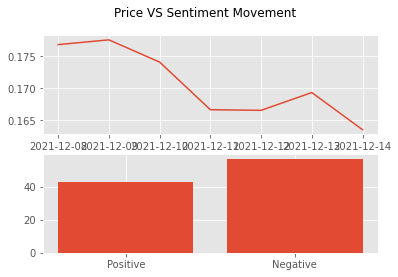

In [234]:
fig, axs = plt.subplots(2) 
fig.suptitle('Price VS Sentiment Movement')
axs[0].plot(sentiment_df['End'], sentiment_df['AveragePrice']) 
axs[1].bar(['Positive','Negative'], [overallsentiment[1], overallsentiment[2]])

plt.show()

## Conclusion

The graph above shows the Dogecoin prices in the last week. As we can see, the prices for Dogecoin have been steadily declining except for a small hike on 13th December after which the price dropped even more. On the other hand, the bar chart below shows the overall percentage of positive and negative tweets on twitter in regards to Dogecoin prices in the past week. As visible, majority of the people tweeted negatively about the twitter price. And after comparing both our graphs, we can conclude that although the Dogecoin prices and tweet sentimentalities are in sync, they are faintly corelated.

### Extracting More Data Beyond 7 days
Here, we will mainting an external csv file where we will store data. **We will run the below code daily until we have collected significant data and then try our analytics on that to see how the results vary.**
<br>We have not used this data yet because we have only collected this for one day. We are not looping this over a certain number of K cases because we are trying to extract and append future data to csv file and thus cannot run a code for 24 hours straight.

In [ ]:
#We run the same extraction code for "today" as end date and "yesterday" as start date. 

search = "#Dogecoin since:" + str(yesterday) + " until:" + str(today)
tweet_cursor = tweepy.Cursor(api.search_tweets, q=search, lang='en', tweet_mode ='extended').items(1000)
tweets = [tweet.full_text for tweet in tweet_cursor]
tweets_df = pd.DataFrame(tweets, columns = ['Tweets'])
        
for _, row in tweets_df.iterrows():
        row["Tweets"] = re.sub('http\S+', '', row['Tweets'])
        row["Tweets"] = re.sub('#\S+', '', row['Tweets'])
        row["Tweets"] = re.sub('@\S+', '', row['Tweets'])
        row["Tweets"] = re.sub('\\n', '', row['Tweets'])

tweets_df['Polarity'] = tweets_df['Tweets'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
tweets_df['Result'] = tweets_df['Polarity'].map(lambda pol: '+' if pol > 0 else '-')
tweets_df.to_csv('TweetsDaily.csv', mode='a') #We use mode = "a" so it appends the new data not overwrites it

# CHECKPOINT 2:

## 2. Does an individual user’s tweet influence the Dogecoin Prices and if so which users?


**What it does:** The cell below givees parses across a website that consists of the top crypto currency experts and returns their twitter handles. 


**How it works & Problem Solving:** We accomplish this by first obtaining the HTML code of the website and then convert it into XML format. We then run through the XML file and store all the tags with the twitter handles in a list. Once stored in the list, we then convert the entire list data into XML format by storing the experts' rank as tags, and their name, twitter handle and csv filename as the attributes. Before converting the list into XML format, we clean the data manually by removing the items in the list that do not have a twitter handle, or the twitter handles of people who deleted their twitter account. We also replace the old handles with new handles for the people who have updated their username. We finally end up with an XML file that conists of all the information for each expert.

In [210]:
def getTwitterHandles():
    
    '''
    Function for scraping all the twitter handles of the top one hundred influencer.
    name: getTwitterHandles()
    paramter: none
    return: list of twitter handles
    '''

    website_url = requests.get("https://cryptoweekly.co/100/").text # website url for the top 100 crypto influencers
    
    soup = BeautifulSoup(website_url, "lxml") # extracting the HTML code of the website using beautiful soup
    profiles = soup.findAll("div", {"class":"twitte crypto-text-color-blue"}) # extracting lines of HTML code that consists of the twtter handles 
    
    twitterHandles = [] # creating empty list which stores twitterHandles
    for i in profiles:
        match = re.search(r'\@[A-Za-z_0-9]*', str(i)) # using regular expressions to just extract the twitter handle out of the line of HTML code
        twitterHandles.append(match.group(0)[1:]) # to remove the '@' in the beginning
    
    """
    The following lines of code help with changes in the twitter handles of people who have changed their handles
    since the date the post on the website was created.
    """

    for i in range(len(twitterHandles)): 
        if twitterHandles[i] == 'michael_saylor': # old twitter handle
            twitterHandles[i] = 'saylor' # new twitter handle
            continue
    
    """
    The following lines of code help with elimination of those twitter handlees who either don't exist anymore or for 
    the people who have deleted their twitter account itself.
    """
    
    twitterHandles = [x for x in twitterHandles if x != '']
    twitterHandles.remove('jlvdv') # deleted twitter account
    twitterHandles.remove('jinglanW') # deleted twitter account
    twitterHandles.remove('joyce') # deleted twitter account
    
    return twitterHandles # returns the updated list of twitter handles

getTwitterHandles() # prints the list of handles for the user

['cz_binance',
 'VitalikButerin',
 'jihanwu',
 'BarrySilbert',
 'brian_armstrong',
 'iohk_charles',
 'saylor',
 'jack',
 'RaoulGMI',
 'Kris_HK',
 'SBF_Alameda',
 'Melt_Dem',
 'novogratz',
 'gavofyork',
 'adam3us',
 'sergeynazarov',
 'CaitlinLong_',
 'dannyryan',
 'dan_schulman',
 'CathieDWood',
 'chamath',
 'tyler',
 'haydenzadams',
 'ethereumJoseph',
 'rleshner',
 'jerallaire',
 'cameron',
 'JedMcCaleb',
 'StaniKulechov',
 'AndreCronjeTech',
 'pmarca',
 'twobitidiot',
 'OneMorePeter',
 'gavinandresen',
 'kaiynne',
 'starkness',
 'spair',
 'sammcingvale',
 'bobbyong',
 'polychain',
 'jespow',
 'vansa_c',
 'RuneKek',
 'bengoertzel',
 'BlockFiZac',
 'dan_pantera',
 'coinmarketcap',
 'evankuo',
 'ptj_official',
 'breitwoman',
 'nejc_kodric',
 'ssrinawakoon',
 'aantonop',
 'naval',
 'brendanblumer',
 'ErikVoorhees',
 'brianbrooksocc',
 'galiabenartzi',
 'SatoshiLite',
 'cdixon',
 'apompliano',
 'NickSzabo4',
 'arrington',
 'lopp',
 'VinnyLingham',
 'CharlieShrem',
 'timdraper',
 'laurashin

### Scraping Individual User Tweets

**What it does:** The cell below goes calls the getTwitterHandles() function and sends out each of the twitter handles to another function. The get_all_tweets() function, goes through each tweet of that user and saves the last 3000 tweets of that user in individual csv files.

**How it does:** Although we are using the twitter api to get the tweets, we filter out the id, text, and date out of the other irrelevant information from those tweets using regular expressions and list comprehension. Moreover we use the LoL format to save the tweets and finally save them in a csv file. The csv file of each expert, consists of the tweet id, creation date and the twitter text. 

**Note: The pause in the middle of the code is so that our api does not reach rate limit and we can continue extracting tweets without the code stopping.** <br>
**The csv files get saved in the documents folder**

In [211]:
def get_all_tweets(screen_name): 
    
    '''
    Function for scraping the tweets using the twitter handle and saving them in a file.
    name: get_all_tweets
    parameter: string - twitter handle
    return: none
    '''
    
    print("Getting tweets from @" + screen_name) # printing the handle of the person whose tweet we extract 
    
    auth = tweepy.OAuthHandler(api_key, api_key_secret) # we create an object called auth that uses OAuthHandler call back which takes in api key and api secret as parameters
    auth.set_access_token(access_token, access_token_secret) # using auth, we gain access to the api using the access token and access secret
    api = tweepy.API(auth) # finally we store the access in api for future purposes
    
    '''
    The next few lines are done in order to fill in some intial tweets in new_tweets so that when we later run the 
    program, we only stop when there are no more tweets to be added for that user.
    '''
    alltweets = [] # empty list which stores all the tweets for each user
    
    new_tweets = api.user_timeline(screen_name = screen_name, count = 200) # store the first 200 tweets of the user using their screen name

    alltweets.extend(new_tweets) # appending the first 200 tweets of the person in alltweets
   
    oldest = alltweets[-1].id - 1 # getting the tweet id of the last tweet we stored in alltweets
    
    while len(new_tweets) > 0: # condition so that tweets are not added once the 3000 mark is reached. The above code lines were written so that the code did not terminate here
        print("Getting tweets before %s" % (oldest)) # printing live information to user
        
        new_tweets = api.user_timeline(screen_name = screen_name, count = 200, max_id = oldest) # extracting a new set of 200 tweets strating from the previous tweet id
        
        alltweets.extend(new_tweets) # appending the new set of 200 tweets 
      
        oldest = alltweets[-1].id - 1 # updating the oldest tweet id to last tweet id appended in the new batch of 200 tweets
        
        print("...%s tweets downloaded so far" % (len(alltweets))) # live information for the user to know how many tweets have been scraped till that moment in time
    
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in alltweets] # storing information about the tweets in a list for each user
    
    with open(f'{screen_name}_tweets.csv', 'w') as f: # opening a new file for each user as per their twitter handle name
        writer = csv.writer(f) # writing a csv file
        writer.writerow(["id","created_at","text"]) # labeling the first row
        writer.writerows(outtweets) # exporting all the tweets for that particular user in the particular order

    pass # continues to the next user


handles = getTwitterHandles() # gets the list of the twitter handles from the previous function

for i in range(0, (int(len(handles)/2))): # runs a loop for the first half of the twitter handles
    get_all_tweets(str(handles[i])) # calls the get_all_tweets function for each twitter handle

time.sleep(1000) #timer because twitter api restrics the amount of tweets in one run

for i in range((int(len(handles)/2)), len(handles)): #runs a loop for the second half of the twitter handles
    get_all_tweets(str(handles[i])) # calls the get_all_tweets function for each twitter handle

Getting tweets from @cz_binance
Getting tweets before 1460654468068896768
...400 tweets downloaded so far
Getting tweets before 1447845172503617535
...599 tweets downloaded so far
Getting tweets before 1430599921518874624
...798 tweets downloaded so far
Getting tweets before 1421643905519345667
...998 tweets downloaded so far
Getting tweets before 1414590172704886784


KeyboardInterrupt: 

### Getting the number of tweets regarding Dogecoin tweeted by each expert


**What it does:** The cell below using the twitter handles goes through each of the csv files in our folder and return the number of tweets each expert makes regarding Dogecoin irrespective of it being positive or negative. 


**How it does & Problem Solving:** Using the XML file we had originally created that consisted of the expert information, we run throught each cvs file which we obtained in the previous function. We read the csv file and convert it into a pandas dataframe. After that, we go through each row i.e each tweet and check if the tweet text consists of the word 'dogecoin' or 'doge'. For accuracy, we convert the tweet into lowercase so as to check the terms without worrying about their capitalization. 

**Note: We use 'doge' and 'dogecoin' as the only keywords due to them being the most famous terms of usage**

In [212]:
def get_Expert_dogecount(handle): 
    '''
    The function takes in a twitter handle and returns the number of tweets of that person that consist of the word 
    'dogecoin' or 'doge'.
    name: get_Expert_dogecount()
    parameter: twitterhandle
    return: count of the tweets containing supposed information regarding dogecoin
    '''
    filename = handle + "_tweets.csv" # create a filename with the twitterhandle followed by the generic format for the csv file. The names are on the basis of the file names we created earlier
    df = pd.read_csv(filename) # converting the csv files to pandas dataframe
    rows = len(df.index) # calculate the number of rows in the dataframe or the number of tweets made by that expert
    count = 0 # assigning count as 0. count stores the number of tweets containing the specific terms
    for i in range(rows):
        tweet = df['text'][i]
        tweet = tweet.lower() # converting the tweet to lowercase so as to remove the problem of case-sensitiveness
        if 'doge' in tweet or 'dogecoin' in tweet: # checking for the crypto name and the tag assigned to it by NYSE
            count += 1 # increasing count for every tweet
    
    return count # returning the final count

### Getting the top 5 Experts on Dogecoin by volume

**What it does:** The cell below using the above function gives us the top 5 experts who tweet about Dogecoin by volume.

**How it does & Problem Solving:** Using the list of handles scraped getTwitterHandles() function, we then send each handle to the above function and check their count. We save all the counts for each expert in a parellel list. And then using the max function, we calculate the top 5 tweeters. In order to make this smoother, we run a loop 5 times and each time extract and delete the twitter handle of the top tweeter and their tweet count in the parellel list. 

In [213]:
def get_Top5_Experts():
    '''
    The function first sends out each twitter handle to the get_Expert_dogecount() function using the 
    getTwitterHandles() function. While sending each twitter handle, it appends the count of each twitter expert in 
    a parellel list. We then run a loop 5 times (since we would like to get the top 5) and get the experts with the
    max number of tweets regarding Dogecoin by volume. 
    name: get_Top5_Experts()
    parameeter: none
    return: none
    '''
    
    handles = getTwitterHandles() # getting the twitter handles
    countlist = [] # creating a parellel list
    for i in handles:
        countlist.append(get_Expert_dogecount(i)) # sending each handle for getting the count
        
    Expertlist = [] # creating a list of the top 5 Experts by volume
    for i in range(5):
        maxcount = max(countlist) # getting the max count in the current list 
        maxindex = countlist.index(maxcount) # getting the max index for the max count in the current list
        Expertlist.append(handles[maxindex] + '_tweets.csv') # appending the expert at the max index
        del countlist[maxindex] # deleting the current max count
        del handles[maxindex] # deleting the twitter handle for the expert already added into the list
        
    return(Expertlist)


get_Top5_Experts()

['coinmarketcap_tweets.csv',
 'VinnyLingham_tweets.csv',
 'tyler_tweets.csv',
 'cameron_tweets.csv',
 'BarrySilbert_tweets.csv']

### Comparing the sentimentant of the experts' tweets with the Dogecoin price for that day

**What it does:** The cell below takes in the top 5 expert list and parses through their tweets from their csv file and calculates the sentiment of each of their tweets. It then compares the sentiment of that tweet with the prices of Dogecoin and checks the accuracy of each expert for each sentiment. In the end, it prints the average accuracy for each expert. 

**How it does & Problem Solving:** Similar to the first question, we use the map function to get the polarity and sentiment of each of the tweets saved in the csv file for each of the experts. For each tweet, we look at it's creation date and get the price curve for Dogecoin for that day by comparing the open and closing price for that day. We then compare the the sentiment of the tweet with the price curve for that day and if they both allign with each other, we increase the accuracy of the expert. We repeat this for each tweet of every expert. While calculating the accuracy, we also simulatenously calculate the average accuracy until that point. Finally, we store all of this information in a dictionar with the handle of the expert as the key and their accuracy as the value.

In [214]:
Expertlist = get_Top5_Experts()

def user_sentiment(Expertlist):
    '''
    The function's objective is to get each user's accuracy in predicting dogecoin prices. 
    To do this, we first loop through each csv file and get sentiment of each tweet on each day. 
    Next, we filter the data based on the amount of dates the Dogecoin price API has given us: we only operate the common data in them
    Once done, we see correlation in prediction and prices and calculate accuracy, like we did in part 1. 
    name: get_Top5_Experts()
    parameeter: Expertlist -> list of all the csv filenames of all the top 5 dogecoin users
    return: Accuracy_each_user -> dictonary with user profile and accuracy
    '''
    
    Accuracy_each_user = {}
    for profile in Expertlist: #iteration over each file
        
        filepath = profile
        usertweets_df = pd.read_csv(filepath)
        
        #getting polarity and sentiment of each tweet of each user
        usertweets_df['Polarity'] = usertweets_df['text'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
        usertweets_df['Sentiment'] = usertweets_df['Polarity'].map(lambda pol: 'positive' if pol > 0 else 'negative') #Checking the polarity
        
        #NOTE: the free API has only 880 dates therefore we use data with only 880 values
        usertweets_df = usertweets_df.iloc[0:881] #because the free version of api only gives us prices from last 883 days, so we use last 880 days of tweets of user
        dates = [i[0:10] for i in usertweets_df['created_at']]
        
        direction = [] #direction of daily movement of price
        
        
        for i in (range(len(dates))):
            
            #to avoid unexpected errors
            if(i == 880):
                break
                
            #only operating on dates that are common in both usertweets_df and API dates
            if((dates[i] not in data["Time Series (Digital Currency Daily)"]) or (dates[i+1] not in data["Time Series (Digital Currency Daily)"])):
                continue
                
            #getting opening and closing price on each day
            openPrice = float(data["Time Series (Digital Currency Daily)"][dates[i]]['1a. open (USD)']) #finding opening price; i[0] is the start date
            closePrice = float(data["Time Series (Digital Currency Daily)"][dates[i+1]]['4a. close (USD)']) #finding closing price
            
            #finding the trend and appending it to the direction
            if(closePrice - openPrice > 0):
                direction.append("Upward")
            else:
                direction.append("Downward")
        
        #making the direction list and direction column of same length
        usertweets_df = usertweets_df.iloc[0:len(direction)] #removing excess values (usually only 1 or 2)
        usertweets_df['Direction'] = direction #adding a new column to our data
        
        
        
        #Finding how accurate our findings were:
        Accuracy = 0
        for i in range(len(usertweets_df['Sentiment'])):
            if((usertweets_df['Sentiment'].iloc[i] == 'positive') and (usertweets_df['Direction'].iloc[i] == 'Upward')): #Checking if price was upward when sentiment was positive
                Accuracy += 1 #number of times it was accurate is incremented
            elif((usertweets_df['Sentiment'].iloc[i] == 'negative') and (usertweets_df['Direction'].iloc[i] == 'Downward')): #Checking if price was downward when sentiment was negative
                Accuracy += 1
        
        Accuracy_each_user[profile[0:-11]] = (Accuracy/len(usertweets_df)*100) #Getting percentage accuracy and appending to our dictionary with their respective twitter profiles
       
    return(Accuracy_each_user)
        

user_sentiment(Expertlist)

{'coinmarketcap': 50.0,
 'VinnyLingham': 50.34090909090909,
 'tyler': 48.97727272727273,
 'cameron': 47.95454545454545,
 'BarrySilbert': 52.38636363636363}

## Result
After extracting the twitter handles of the top experts on cryptocurrencies and saving all their tweets in a csv file, we filter out the top experts on Dogecoin. And on comparing their tweets with the price of Dogecoin for that day, we notice that all of them have around **50% accuracy.** This goes on to highlight the fact that following the advices of these experts is **equivalent to tossing a coin and making decisions.** These experts might be considered geniuses but purchasing and selling Dogecoin on the basis of their tweets has **only 1 out of 2 chances of being right.** And thus, using your knowledge, research, and calculation is a much better method than just blindly following twitter and trading Dogecoin. 

coinmarketcap_tweets.csv


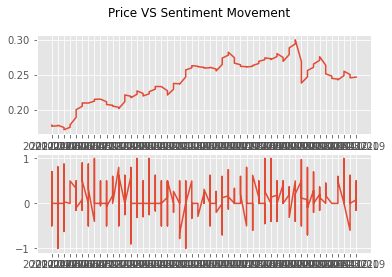

VinnyLingham_tweets.csv


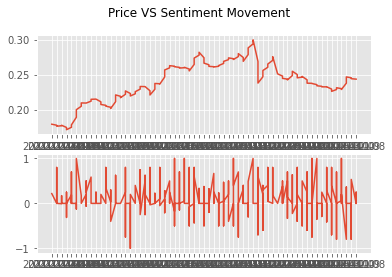

tyler_tweets.csv


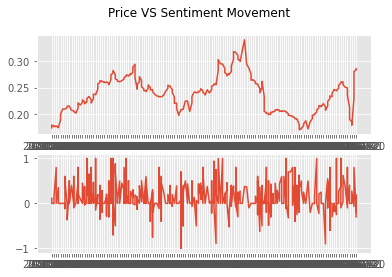

cameron_tweets.csv


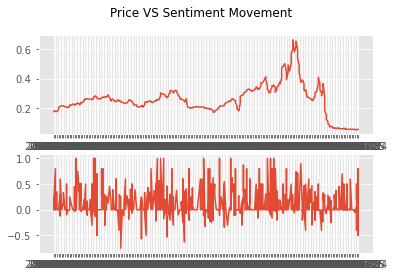

BarrySilbert_tweets.csv


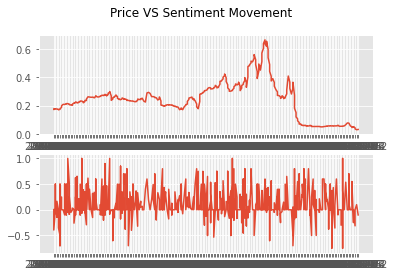

{'coinmarketcap': 50.0,
 'VinnyLingham': 50.34090909090909,
 'tyler': 48.97727272727273,
 'cameron': 47.95454545454545,
 'BarrySilbert': 52.38636363636363}

In [215]:
volume_std = np.std(volume_df['Volume'])
priceDiff_std = np.std(volume_df['priceDifference'])

Accuracy_each_user = {}
for profile in Expertlist: #iteration over each file

    filepath = profile
    usertweets_df = pd.read_csv(filepath)

    #getting polarity and sentiment of each tweet of each user
    usertweets_df['Polarity'] = usertweets_df['text'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
    usertweets_df['Sentiment'] = usertweets_df['Polarity'].map(lambda pol: 'positive' if pol > 0 else 'negative') #Checking the polarity

    #NOTE: the free API has only 880 dates therefore we use data with only 880 values
    usertweets_df = usertweets_df.iloc[0:881] #because the free version of api only gives us prices from last 883 days, so we use last 880 days of tweets of user
    dates = [i[0:10] for i in usertweets_df['created_at']]

    averagePrice = [] 

    for i in (range(len(dates))):

        #to avoid unexpected errors
        if(i == 880):
            break

        #only operating on dates that are common in both usertweets_df and API dates
        if((dates[i] not in data["Time Series (Digital Currency Daily)"]) or (dates[i+1] not in data["Time Series (Digital Currency Daily)"])):
            continue

        #getting opening and closing price on each day
        openPrice = float(data["Time Series (Digital Currency Daily)"][dates[i]]['1a. open (USD)']) #finding opening price; i[0] is the start date
        closePrice = float(data["Time Series (Digital Currency Daily)"][dates[i+1]]['4a. close (USD)']) #finding closing price

        averagePrice.append((closePrice+openPrice)/2)
        
    usertweets_df = usertweets_df.iloc[0:len(averagePrice)] #removing excess values (usually only 1 or 2)
    usertweets_df['averagePrice'] = averagePrice
        
    dates = [usertweets_df['created_at'].iloc[i][0:10] for i in range(len(usertweets_df['created_at']))]
    
    print(filepath)
    fig, axs = plt.subplots(2)
    fig.suptitle('Price VS Sentiment Movement')
    axs[0].plot(dates, usertweets_df['averagePrice'])
    axs[1].plot(dates, usertweets_df['Polarity'])

    plt.show()
    
    
    
user_sentiment(Expertlist)

## Conclusion
Above we have five different pair of graphs for each of the top five experts. In each pair, the top graph shows the price of Dogecoin over time while the bottom graph shows the sentiment of the experts tweet regarding Dogecoin prices over time. 

In each pair of graphs we can observe that the sentiments and prices allign at random times upto random limits without any kind of definite pattern or flow. This goes on to reinforce our original result that dogecoin experts are correct only half of the times. And after comparing each pair of graphs, we can conclude that trading on the basis of advice from tweet sentiments of experts has as much chances of giving you a profit as much as loss. 

# CHECKPOINT 3
## Does the volume of tweets on a particular day about Dogecoin affect the price movements of Dogecoin?


## By Volume

**What it does:** The cell below takes in the two consecutives dates as the first two parameters and the hour for which the number tweets need to calculated as the final parameter. Using the above three parameters, it returns all the time stamp of all the tweets containing the word "Dogecoin" for the given dates at the given hour.

**How it does & Problem Solving:** We take in two consecutive dates so as to calculate the tweets for the date taken as the first parameter. Since tweets are extracted in reverse time, the second date helps the API to start before 12:00 am of the second parameter and continue till the give hour (in 24-hour format). We then convert each tweet into a string and extract the date and time using index boundaries. We keep appending the date and time string for each tweet in a list and alongside also keep a count of the rate limit to make sure that the code does not sure an error incase we surpass the rate limit. Finally we return the list of dates and times as well as the rate limit so that the next time the function runs, the rate limit is not set back to zero, but rather continues with the previous value.

In [125]:
def get_tweet_volume(start, end, hour):
    
    search = "#Dogecoin since:" + start + " until:" + end #Query String that is passed to the API Cursor which then scraps data.
    tweet_cursor = tweepy.Cursor(api.search_tweets, q=search, lang='en', tweet_mode ='extended').items() #Here, 200 is the number of tweets we will get

    tweets = 0
    ratelimit = 0
    
    flag = False

    for tweet in tweet_cursor:
        if(ratelimit > 1000):
            time.sleep(1000)
            flag = True
        else:
            print(tweet.created_at)
            if( int(str(tweet.created_at)[11:13]) < hour ):
                break
            else:
                print(tweet.created_at)
                tweets = tweets + 1
                ratelimit = ratelimit + 1
                
                if(flag == True):
                    ratelimit = 0
                    flag = False
                
    return([tweets, ratelimit])

get_tweet_volume('2021-12-11', '2021-12-12', 23)

2021-12-11 23:59:59+00:00
2021-12-11 23:59:59+00:00
2021-12-11 23:59:24+00:00
2021-12-11 23:59:24+00:00
2021-12-11 23:59:13+00:00
2021-12-11 23:59:13+00:00
2021-12-11 23:59:09+00:00
2021-12-11 23:59:09+00:00
2021-12-11 23:59:03+00:00
2021-12-11 23:59:03+00:00
2021-12-11 23:58:47+00:00
2021-12-11 23:58:47+00:00
2021-12-11 23:58:39+00:00
2021-12-11 23:58:39+00:00
2021-12-11 23:58:39+00:00
2021-12-11 23:58:39+00:00
2021-12-11 23:58:35+00:00
2021-12-11 23:58:35+00:00
2021-12-11 23:58:28+00:00
2021-12-11 23:58:28+00:00
2021-12-11 23:58:22+00:00
2021-12-11 23:58:22+00:00
2021-12-11 23:58:07+00:00
2021-12-11 23:58:07+00:00
2021-12-11 23:57:53+00:00
2021-12-11 23:57:53+00:00
2021-12-11 23:57:51+00:00
2021-12-11 23:57:51+00:00
2021-12-11 23:57:49+00:00
2021-12-11 23:57:49+00:00
2021-12-11 23:57:46+00:00
2021-12-11 23:57:46+00:00
2021-12-11 23:57:45+00:00
2021-12-11 23:57:45+00:00
2021-12-11 23:57:45+00:00
2021-12-11 23:57:45+00:00
2021-12-11 23:57:44+00:00
2021-12-11 23:57:44+00:00
2021-12-11 2

[680, 680]

**What it does:** Returns the list of date and time for all the tweets at a particular hour in the past week.  

**How it does & Problem Solving:** The function first uese our original Date list which consisted of the tweets from the past week. It then parses through each date and then sends it to te get_tweet_volume() function in order to get tweets for that particular day at the given hour. While we are appending the date and time stamps, we make sure to not cross the rate limit and if at any point it does, we ask the function to sleep until the rate limit is refreshed. The best part about this function is that the rate limit is a dynamic variable in a way that keeps updating it's value in the previous as well as the function below.

**Note:** For simplicity purposes, we have only extracted tweets between 21:00 and 23:00 hours. The reason being that the number of tweets during that time are much less as compared to that during daytime. Although,| theoretically we could extract tweets for any time of the day, doing so with only elevated access to Twitter might take more than half a day.

In [149]:
def tweet_volume_week(Dates, hour):
    
    VolumeLoL = []
    ratelimit = 0
    flag = False
    
    for i in range(len(Dates)):
        
        #Getting start and end Dates
        start = str(Dates[i][0])
        end = str(Dates[i][1])
        EndDateAppend = [end]
        
        if(ratelimit > 500):
            time.sleep(1000)
            flag == True
        
        else:
            
            if(flag == True):
                ratelimit = 0
                flag = False
                
            if(flag == False):
                volumeData = get_tweet_volume(start, end, hour)
                volume = volumeData[0]
                ratelimit = volumeData[1]
        
        EndDateAppend.append(volume)
        VolumeLoL.append(EndDateAppend)

    return(VolumeLoL)

VolumeLoL = tweet_volume_week(Dates, 23)

2021-12-07 23:59:59+00:00
2021-12-07 23:59:59+00:00
2021-12-07 23:59:57+00:00
2021-12-07 23:59:57+00:00
2021-12-07 23:59:48+00:00
2021-12-07 23:59:48+00:00
2021-12-07 23:59:41+00:00
2021-12-07 23:59:41+00:00
2021-12-07 23:59:40+00:00
2021-12-07 23:59:40+00:00
2021-12-07 23:59:38+00:00
2021-12-07 23:59:38+00:00
2021-12-07 23:59:32+00:00
2021-12-07 23:59:32+00:00
2021-12-07 23:59:24+00:00
2021-12-07 23:59:24+00:00
2021-12-07 23:59:22+00:00
2021-12-07 23:59:22+00:00
2021-12-07 23:59:18+00:00
2021-12-07 23:59:18+00:00
2021-12-07 23:59:17+00:00
2021-12-07 23:59:17+00:00
2021-12-07 23:59:04+00:00
2021-12-07 23:59:04+00:00
2021-12-07 23:59:00+00:00
2021-12-07 23:59:00+00:00
2021-12-07 23:58:56+00:00
2021-12-07 23:58:56+00:00
2021-12-07 23:58:54+00:00
2021-12-07 23:58:54+00:00
2021-12-07 23:58:54+00:00
2021-12-07 23:58:54+00:00
2021-12-07 23:58:49+00:00
2021-12-07 23:58:49+00:00
2021-12-07 23:58:35+00:00
2021-12-07 23:58:35+00:00
2021-12-07 23:58:28+00:00
2021-12-07 23:58:28+00:00
2021-12-07 2

KeyboardInterrupt: 

### Using the data that we extracted and updated in the csv file

In [128]:
import pandas as pd
import os

filepath = "./tweetsvolume.csv"

volume_df = pd.read_csv(filepath)
volume_df

,EndDate,Time,Volume
0,2021-12-14,23:00:00,1361
1,2021-12-14,22:00:00,1910
2,2021-12-14,21:00:00,1958
3,2021-12-13,23:00:00,1178
4,2021-12-13,22:00:00,1380
5,2021-12-13,21:00:00,1258
6,2021-12-12,23:00:00,1078
7,2021-12-12,22:00:00,1253
8,2021-12-12,21:00:00,1159
9,2021-12-11,23:00:00,683


### Getting Intraday Dogecoin Data from API

**What it does:** It takes intraday data for a 60 minute time interval.

**How it does & Problem Solving:** We create a correct url by accurately entering the following items: <br>
CRYPTO_INTRADAY: Refers to the fact that we need prices for a particular crypto in a given day <br>
symbol: Refers to 'DOGE' which is the symbol for our crypto <br>
60min: Refers to the way we get the prices in 60 minute intervals <br>
APIkey: Refers to our API key which we got earlier <br>
outputsize = full: Refers to the fact that we need the entire data in one go instead of getting it in intervals of 200

In [156]:
symbol = "DOGE" #crypto symbol
APIkey = '8KUJ36BZP06HRKQR' 
url = 'https://www.alphavantage.co/query?function=CRYPTO_INTRADAY&symbol=' + symbol + '&market=USD&interval=60min&apikey=' + APIkey + '&outputsize=full&datatype=json'
r = requests.get(url) #calling data
intradayData = r.json() #extracting data

### Adding PriceDifference to volume_df

**What it does:** The function calculates the price difference for each hour in each day and creates a list that stores all of this information.

**How it does & Problem Solving:** We start with going through each of our days in our volume_df list. For each day, we extract the date and hour using string functions and append it to the volume_df dataframe. We then, for each day, go through each timestamp of the intradayData dictionary (keys of the dictionary) that we calculated in the previous cell. For each timestamp, we derive the closing and opening price and calcualate the price difference by comparing them. We finally append the price difference to a list which after recursion through the entire nested loop gets added to the volume_df dataframe.

In [146]:
keys = list(intradayData["Time Series Crypto (60min)"].keys())


priceDifference = []
for i in range(len(volume_df)):
    date = volume_df.iloc[i]['EndDate']
    hour = volume_df.iloc[i]['Time'][0:2]
    for timestamp in intradayData["Time Series Crypto (60min)"].keys():
        if(timestamp[0:10] == date and timestamp[11:13] == hour):
            closePrice  = float(intradayData["Time Series Crypto (60min)"][timestamp]['4. close'])
            openPrice = float(intradayData["Time Series Crypto (60min)"][timestamp]['1. open'])
            priceDiff = closePrice - openPrice
            priceDifference.append(priceDiff)

volume_df['priceDifference'] = priceDifference

### Checking if Volume and PriceDifference is related or not

**What it does:** Returns the correlation constant using covariance and standard deviation.

**How it does & Problem Solving:** 

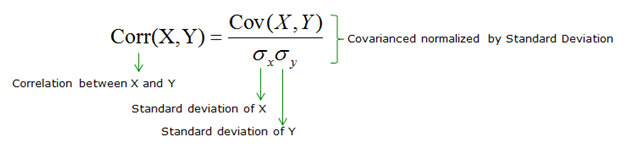

In [147]:
#finding covariance of volume and priceDifference
def covariancePV(volume, priceDifference):
    cov = 0
    averageVolume = sum(volume)/len(volume)
    averagePriceDiff = sum(priceDifference)/len(priceDifference)
    
    for i in range(0, len(volume)):
        cov = cov + (volume[i] - averageVolume) * (priceDifference[i] - averagePriceDiff)
    return (cov / (len(volume)-1))

covariance = covariancePV(volume_df['Volume'], volume_df['priceDifference'])

volume_std = np.std(volume_df['Volume'])
priceDiff_std = np.std(volume_df['priceDifference'])

#converting to numpy arrays
volumenp = np.array(volume_df['Volume'])
priceDiffnp = np.array(volume_df['priceDifference'])

correlation = covariance/(priceDiff_std*volume_std)
print(correlation)

0.3696013286512475


## Result
In general mathematical terms, the correlation constant is any value between [-1,1]. -1 represents that the two variables are inversely correlated while 1 implies that the two variables are completly correlated in the same direction. 0 indicates that there is no correlation at all between the two variables. Since our correaltion after calculation comes out to be around 0.37, we can say that there is a very low overall correlation between the volume of tweets and price difference for each hour. 

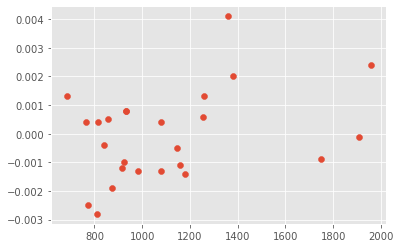

In [148]:
plt.scatter(volumenp, priceDiffnp)
plt.show()

## Conclusion

As we can see in the scatterplot above, our price difference for different volumes is completely random and there is no continuity and thus reassures our claim that the price and volume of tweets have nothing to do with each other. Therefore, the next time you see people tweeting a lot about Dogecoin, don't get too excited and trade in your Dogecoins; it is just a phase and will pass sooner than you realize. 

# Final Conclusion

After comparing and checking Dogecoin prices against several variables and measures, the overall major results are as following: <br>
1. While the overall sentiment of Dogecoin on twitter might not affect the prices of Dogecoin all the time, trading on the basis of the overall sentimentality when your calculations match the senimentality will give you a pretty high rate of making a profit out of the deal. 
<br>
<br>
2. A lot of people may consider crpto experts to be geniuses and master influencers of the crypto price market, in reality, listening to their feeling about Dogecoin and trading accordingly has as many chances of being right as rolling a dice and trading if the number is even or odd. In short, it can go either way and oftentimes, listening to the overall sentiment of twitter rather than just the experts' tweets gives you a better chancee of making a profit (a ratio of 6:5). 
<br>
<br>
3. Just because the number of tweets regarding Dogecoin you see on Twitter are a lot or very rare, does not imply anything about the price of Dogecoin as both the variables are highly unlikely to be correlated. 
<br>
<br>
Thus, our overall conclusion is that although, rumors has it that Twitter is a major platform that influences Dogecoin prices. After our anaylsis, we can assure you that the influence of Twitter is much less than you or we expected it to be. Change of prices in Dogecoin occurs for several other reasons and doing a proper thorough research along with applying genuine algorithms is the only key to making profits in this industry. 

**Note: While these are the findings of our project, we have made a lot of assumptions, ignored many external factors and analysed a very small part of the existing data. We would therefore NOT recommend you or anyone else to trade just on the basis of the above conclusions and analyzations. Although, we DO assure that all the data we have analyzed has been done through completely logical mathematical steps and so the information provided can be actually used as a side method for trading.**